Import all the needed libraries

In [1]:
!pip install tensorflow kaggle keras scikit-learn visualkeras modAL scikeras scikit-activeml

In [2]:
pip install git+https://github.com/modAL-python/modAL.git

  Cloning https://github.com/modAL-python/modAL.git to /tmp/pip-req-build-8wilifgd
  Running command git clone --filter=blob:none --quiet https://github.com/modAL-python/modAL.git /tmp/pip-req-build-8wilifgd
  Resolved https://github.com/modAL-python/modAL.git to commit bba6f6fd00dbb862b1e09259b78caf6cffa2e755
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import modAL
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import matplotlib as mpl
import seaborn as sns
from scikeras.wrappers import KerasClassifier
from scipy.io import loadmat
from skimage import color
from skimage import io
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import os
import time
import itertools
from __future__ import absolute_import
from __future__ import print_function
from datetime import timedelta
import h5py
import keras
import visualkeras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
import sklearn
from sklearn import neighbors, metrics
from PIL import ImageFont
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from IPython import display
from matplotlib import pyplot as plt
from skactiveml.utils import MISSING_LABEL, labeled_indices, unlabeled_indices
from skactiveml.visualization import plot_utilities, plot_decision_boundary
from skactiveml.pool import ProbabilisticAL

np.random.seed(20)
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

2023-09-29 17:28:07.763337: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-29 17:28:14.920688: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-29 17:28:26.075666: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
TENSORBOARD_SUMMARIES_DIR = '/tmp/svhn_classifier_logs'

The following code is used to convert the images from rgb to greyscale

In [5]:
def rgb2gray(images):
    return np.expand_dims(np.dot(images, [0.2990, 0.5870, 0.1140]), axis=3)

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix', cmap=plt.cm.tab20b):
    """
    This function prints and plots the confusion matrix. 
    Normalization can be applied by setting normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm. sum (axis=1)[:, np.newaxis] 
        print("Normalized confusion matrix")
    else:    
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product (range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j]> thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

The following code gets used to plot the images as a terminal output

In [7]:
def plot_images(img, labels, nrows, ncols):
    """ Plot nrows x ncols images
    """
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0])
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])

In [8]:
def get_batch(X, y, batch_size=512):
    for i in np.arange(0, y.shape[0], batch_size):
        end = min(X.shape[0], i + batch_size)
        yield(X[i:end],y[i:end])

In [9]:
def prepare_log_dir():
    '''Clears the log files then creates new directories to place
        the tensorbard log file.''' 
    if tf.gfile.Exists(TENSORBOARD_SUMMARIES_DIR):
        tf.gfile.DeleteRecursively(TENSORBOARD_SUMMARIES_DIR)
    tf.gfile.MakeDirs(TENSORBOARD_SUMMARIES_DIR)

In [10]:
def create_keras_model():
    keras.backend.clear_session()

    model = keras.Sequential([
        
    keras.layers.Conv2D(32, (3, 3), padding='same',
        activation='relu',
    input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
        
    keras.layers.Conv2D(64, (3, 3), padding='same',
        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
        
    keras.layers.Conv2D(128, (3, 3), padding='same',
        activation='relu'),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(128, (3, 3), padding='same',
        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(128, (3, 3), padding='same',
        activation='relu'),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(128, (3, 3), padding='same',
        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),
    
    keras.layers.Dense(10, activation='softmax')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=1e-4, amsgrad=True)
    
    model.compile(optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

    return model

In [11]:
h5f = h5py.File('SVHN_rgb.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]

# Close this file
h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (73257, 32, 32, 3) (73257, 10)
Test set (26032, 32, 32, 3) (26032, 10)


In [12]:
n_initial = 60000
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]

# generate the pool
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)
print('new trainnig dataset', X_pool.shape, y_pool.shape)

new trainnig dataset (13257, 32, 32, 3) (13257, 10)


In [15]:
classifier = KerasClassifier(create_keras_model, epochs=5)

In [16]:
learner = ActiveLearner(
    estimator=classifier,
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial,
    verbose=1
)

Epoch 1/5
1875/1875 [==============================] - 150s 78ms/step - loss: 2.2320 - accuracy: 0.1941
Epoch 2/5
1875/1875 [==============================] - 147s 78ms/step - loss: 1.2799 - accuracy: 0.5590
Epoch 3/5
1875/1875 [==============================] - 146s 78ms/step - loss: 0.7233 - accuracy: 0.7701
Epoch 4/5
1875/1875 [==============================] - 146s 78ms/step - loss: 0.5770 - accuracy: 0.8242
Epoch 5/5
1875/1875 [==============================] - 145s 78ms/step - loss: 0.5030 - accuracy: 0.8482


415/415 [==============================] - 8s 19ms/step


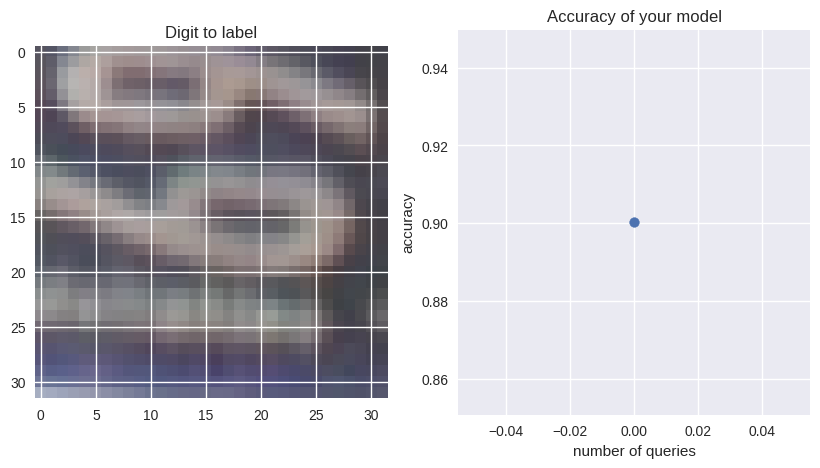

Which digit is this?


 6


Epoch 1/5
1876/1876 [==============================] - 147s 77ms/step - loss: 2.1866 - accuracy: 0.2114
Epoch 2/5
1539/1876 [=======================>......] - ETA: 25s - loss: 1.0825 - accuracy: 0.6418

KeyboardInterrupt: 

In [17]:
score = learner.score(X_test, y_test)
accuracy_scores = [score]
n_queries = 10
for i in range(n_queries):
    display.clear_output(wait=True)
    query_idx, query_inst = learner.query(X_pool, n_instances=1)
    with plt.style.context('seaborn-v0_8'):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title('Digit to label')
        plt.imshow(query_inst[0].reshape(32, 32, 3))
        plt.subplot(1, 2, 2)
        plt.title('Accuracy of your model')
        plt.plot(range(i+1), accuracy_scores)
        plt.scatter(range(i+1), accuracy_scores)
        plt.xlabel('number of queries')
        plt.ylabel('accuracy')
        display.display(plt.gcf())
        plt.close('all')
            
        # ask for a label for the digit being displayed
    print("Which digit is this?")
    selected = int(input())
    y_pool[query_idx] = np.zeros(10, dtype=int)
    y_pool[query_idx][0][selected] = 1
    
    # teach the model with this newly labelled input. fit() would make the model forget everything!
    learner.teach(X_pool[query_idx], y_pool[query_idx])
    X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
    score = learner.score(X_test, y_test)
    accuracy_scores.append(score)

In [18]:
start = time.time()
x_test = X_test
y_true = y_test
y_pred = learner.predict(x_test)
end = time.time()
print("Active Learner Predict Time: ", end - start, "s")

814/814 [==============================] - 15s 19ms/step
Active Learner Predict Time:  16.112298488616943 s


In [19]:
y_true_classes = np.argmax(y_true, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

Confusion matrix, without normalization
[[1560   15    9    0    2    4   90    2    1   61]
 [ 638 4242   39   18   66   12    5   73    1    5]
 [ 487   12 3519   34   23   17    5   37    2   13]
 [ 911   19   29 1677    6  165   14   11   14   36]
 [ 600   32   29   23 1798    9    5    3    1   23]
 [ 319    6    8   61    2 1924   48    4    1   11]
 [ 494   13    3   21   14  103 1306    2    8   13]
 [ 197   59   38    8    3   22    2 1689    0    1]
 [ 792    6   12  103    8   48  105    1  559   26]
 [ 411    4   54    7    3   30   10    6    3 1067]]


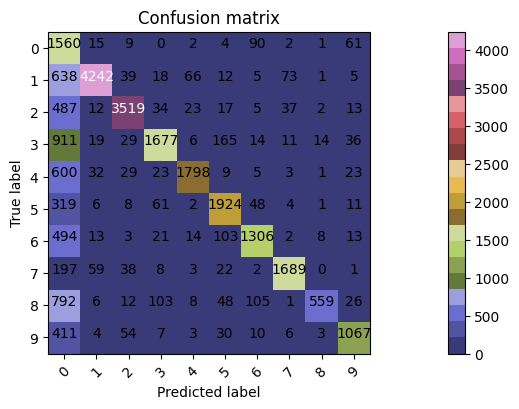

In [20]:
cm = metrics.confusion_matrix(y_true_classes, y_pred_classes)
plot_confusion_matrix(cm, ["0","1","2","3","4","5","6","7","8","9"]) 

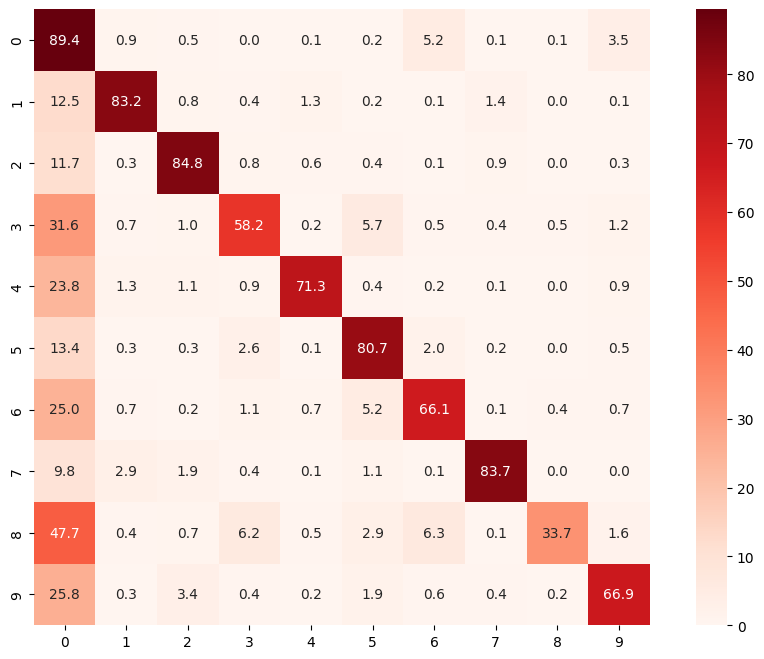

In [21]:
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=y_pred_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.00
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True);

In [22]:
start = time.time()
score = learner.score(x_test, y_true)
print("Test score: {0:.2f} %".format(100 * score))
end = time.time()
print("Active Learner Score Time: ", end - start, "s")

814/814 [==============================] - 15s 19ms/step
Test score: 72.92 %
Active Learner Score Time:  15.980831146240234 s
